Tutorial Link: https://www.kaggle.com/thanaphatj/gender-classification-of-facial-images-cnn/

In [1]:
import os #accessing directory structure
import numpy as np #linear algebra
import pandas as pd #data processing, CSV file I/0 (eg. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt #plotting
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from IPython.display import display
import plotly.express as px

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, experimental, MaxPool2D, BatchNormalization
from tensorflow.keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.data import Dataset
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
from tensorflow.keras.utils import to_categorical
from tensorflow import test
import random

In [2]:
#Set Seed
np.random.seed(1)
set_seed(11)
random.seed(11)

Data Overview:

Age: range 1 - 116

Ethnicity: 0 = white, 1 - Black, 2 = Asian, 3 = Indian, 4 = Other
Gender: 0 = male, 1 = female



Gender Data Scope: 

Biology - 
A boy is usually a fully physically developed man at 18 yrs old

A girl is usually a fully physically developed woman at 16 yrs old

In [3]:
#upload voice file
voice_data = pd.read_csv('/content/drive/MyDrive/SureStart/voice.csv')
voice_data

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,0.200836,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,0.013683,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,0.008006,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,0.212202,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female


In [4]:
#upload facial file
age_gender_data = pd.read_csv('/content/drive/MyDrive/SureStart/age_gender.csv')
age_gender_data

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


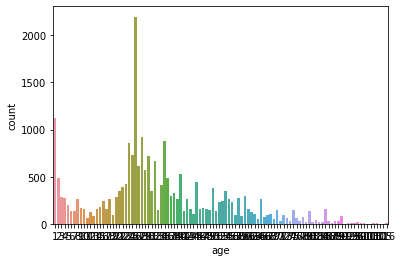

In [5]:
sns.countplot(x='age', data=age_gender_data) #age distribution

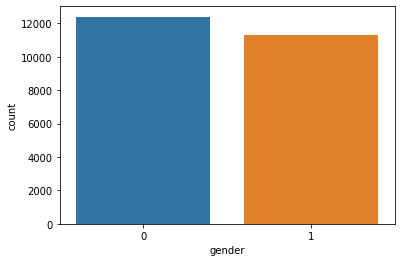

In [6]:
sns.countplot(x='gender', data=age_gender_data) #gender distribution

Data Preprossing

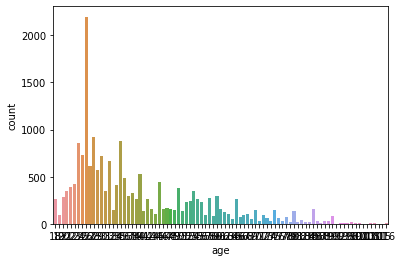

In [7]:
# Select only person who has age more than 18 
age_gender_data = age_gender_data[age_gender_data['age'] >= 18]
sns.countplot(x='age', data=age_gender_data) #age distribution

In [8]:
age_gender_data.reset_index(drop=True, inplace=True)
age_gender_data

,age,ethnicity,gender,img_name,pixels
0,100,0,0,20170112213500903.jpg.chip.jpg,203 185 139 163 176 184 186 175 175 156 159 13...
1,100,0,0,20170112215240346.jpg.chip.jpg,125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2,100,0,1,20170110183726390.jpg.chip.jpg,235 164 113 144 121 201 243 237 234 221 233 23...
3,100,0,1,20170112213001988.jpg.chip.jpg,82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4,100,0,1,20170112213303693.jpg.chip.jpg,70 72 94 149 154 166 175 169 172 161 176 187 2...
...,...,...,...,...,...
19467,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
19468,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
19469,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
19470,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


In [9]:
age_gender_data.isnull().sum() # Check null data

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [10]:
# Input image configuration
num_pixels = len(age_gender_data['pixels'][0].split(' '))
dimension = int(np.sqrt(num_pixels))
img_width = dimension
img_height = dimension

print("Pixels: {}".format(num_pixels))
print("Width: {0}, Height: {1}".format(img_width, img_height))

Pixels: 2304
Width: 48, Height: 48


In [11]:
# Splitting dataset into X and y
X_img = age_gender_data.iloc[:,4].copy()
y_age = age_gender_data.iloc[:,0].copy()
y_ethnicity = age_gender_data.iloc[:,1].copy()
y_gender = age_gender_data.iloc[:,2].copy()

# splitting the data into train and te sets.
X_train, X_te, y_train, y_te = train_test_split(X_img,y_gender,test_size=0.3,random_state=11)
# splitting 'te' set into validation and test set
X_val, X_test, y_val, y_test = train_test_split(X_te,y_te,test_size=0.15,random_state=11)

def str_to_npArr(x):
    '''
    Function to convert pixel data (string) into numpy_array of pixels
    '''
    x = x.reset_index(drop=True)
    x = x.apply(lambda x: np.array(x.split(), dtype="float32")) #converting data to numpy array
    return np.array([x[i].reshape(img_width, img_height, 1) for i in range(x.shape[0])])
# Converting the string of pixels into image array for each of train, val and test set and normalization
X_train = str_to_npArr(X_train)
X_test = str_to_npArr(X_test)
X_val = str_to_npArr(X_val)

print("Traget: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>")
print("Current: shape = {}, type = {}".format(X_train.shape, type(X_train)))

Traget: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>
Current: shape = (13630, 48, 48, 1), type = <class 'numpy.ndarray'>


In [12]:
 target_columns = ['gender', 'ethnicity', 'age']

age_gender_data_preprocess = age_gender_data.drop('img_name', axis=1)
y = age_gender_data_preprocess[target_columns]
X = age_gender_data_preprocess.drop(target_columns, axis=1)

print(X)
print("--------------------------------------------------------")
print(y)

                                                  pixels
0      203 185 139 163 176 184 186 175 175 156 159 13...
1      125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2      235 164 113 144 121 201 243 237 234 221 233 23...
3      82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4      70 72 94 149 154 166 175 169 172 161 176 187 2...
...                                                  ...
19467  127 100 94 81 77 77 74 99 102 98 128 145 160 1...
19468  23 28 32 35 42 47 68 85 98 103 113 117 130 129...
19469  59 50 37 40 34 19 30 101 156 170 177 184 187 1...
19470  45 108 120 156 206 197 140 180 191 199 204 207...
19471  156 161 160 165 170 173 166 177 183 191 187 18...

[19472 rows x 1 columns]
--------------------------------------------------------
       gender  ethnicity  age
0           0          0  100
1           0          0  100
2           1          0  100
3           1          0  100
4           1          0  100
...       ...        ...  ...
19467       1          

In [13]:
X = X['pixels'].apply(lambda x: np.array(x.split(), dtype="float32")) #converting data to numpy array
X = np.array(X)/255.0 # normalization
X = np.array([ X[i].reshape(48,48,1) for i in range(X.shape[0]) ])

print("Traget: X Shape: {}".format(X.shape))
print("Current: X Shape: {}".format(X.shape))

Traget: X Shape: (19472, 48, 48, 1)
Current: X Shape: (19472, 48, 48, 1)


In [14]:
y_gender = np.array(y['gender'])
y_ethnicity = np.array(y['ethnicity'])
y_age = np.array(y['age'])

Data Visualization

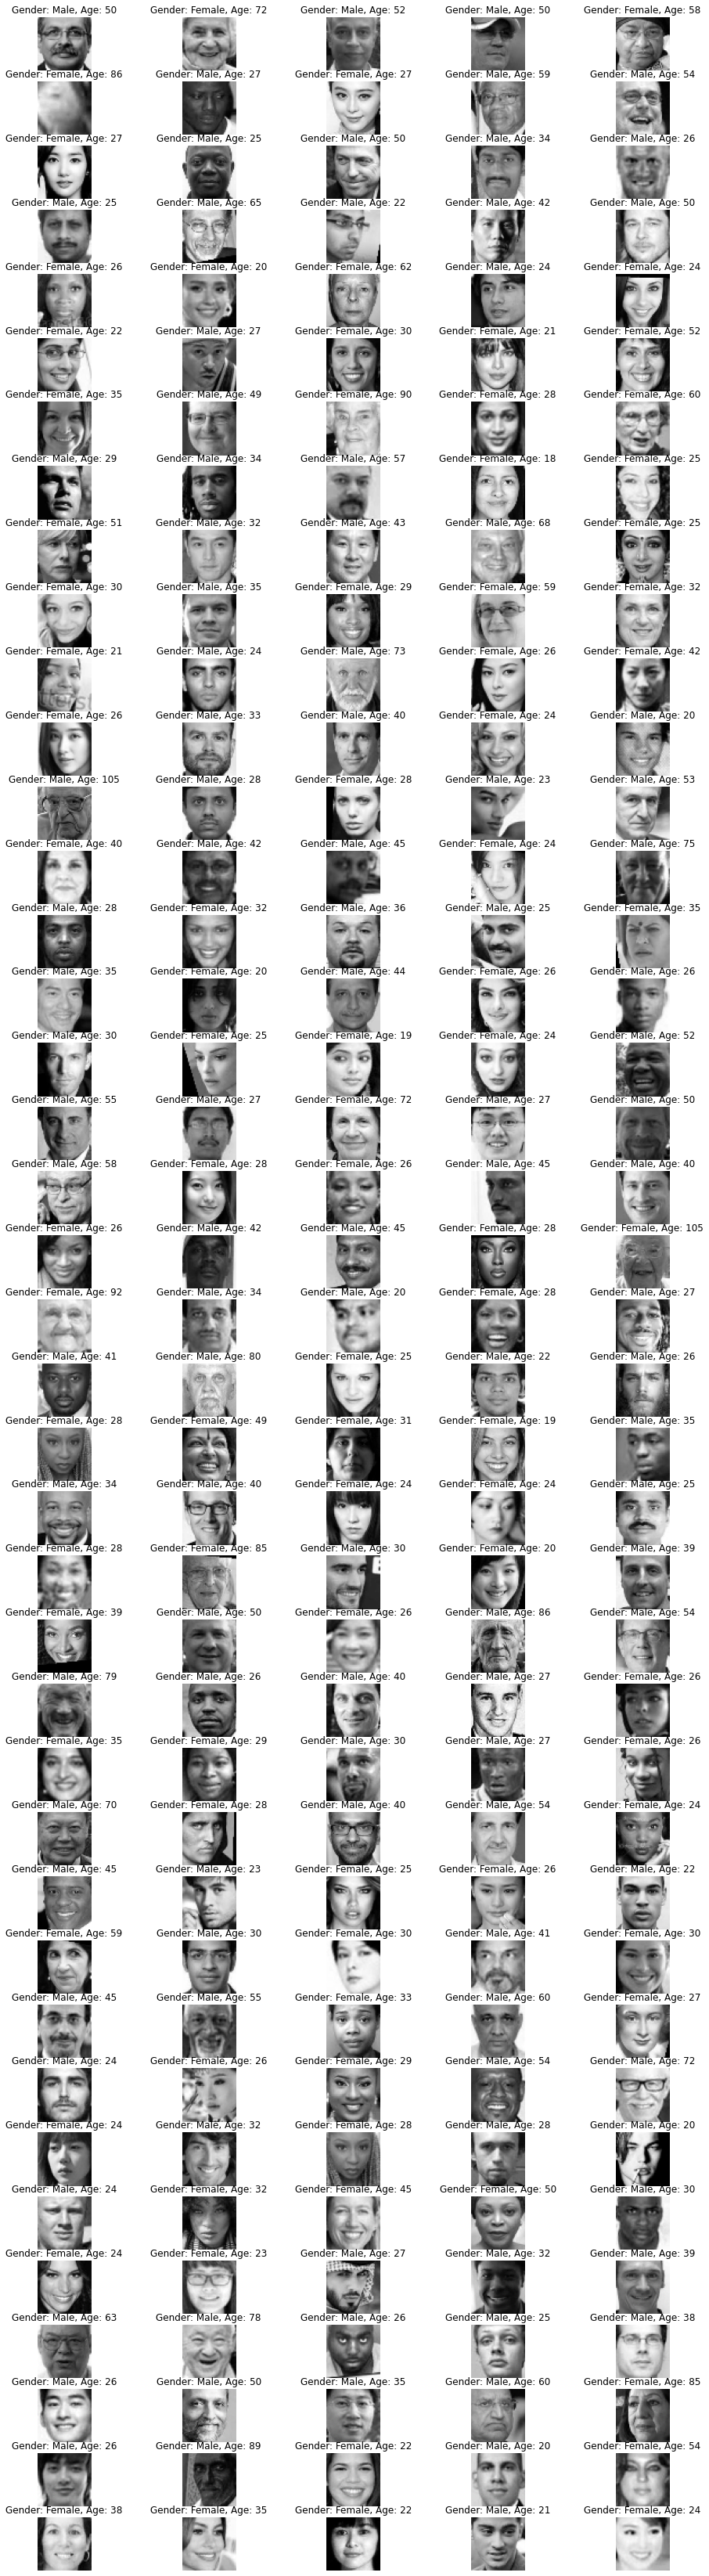

In [15]:
rows = 40 # rows in subplots
cols = 5 # columns in subplots
samp = random.sample(range(X.shape[0]),rows*cols) #selecting 200 random samples
x_samp = X[samp,:,:,:]
y_samp_gender = y_gender[samp]
y_samp_age = y_age[samp]
    
fig,ax = plt.subplots(rows,cols,figsize=(16,60))
r = 0
c = 0   

for i in range(rows*cols):
    aa = x_samp[i,:,:,:].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    ax[r,c].set_title(f"Gender: {'Female' if y_samp_gender[i]==1 else 'Male'}, Age: {y_samp_age[i]}")
    c+=1
    if c == cols:
        c=0
        r+=1
        
plt.show()

Data augmentation: a technique to increase the diversity of your training set by applying random (but realistic) transformations such as image rotation. This code below shows 100 samples of Data augmentation.

In [16]:
train_data_gen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=1,
                                    brightness_range=[0.8,1.2],
                                    zoom_range=[0.8,1.2],
                                    rescale=1/255
                                   )
val_data_gen = ImageDataGenerator(rescale=1/255)

test_data_gen = ImageDataGenerator(rescale=1/255)


In [17]:
set_seed(11)
random.seed(11)
np.random.seed(11)

val_data = val_data_gen.flow(X_val,y_val,
                                   seed=11,shuffle=False)

test_data = test_data_gen.flow(X_test,y_test,
                                   seed=11,shuffle=False)

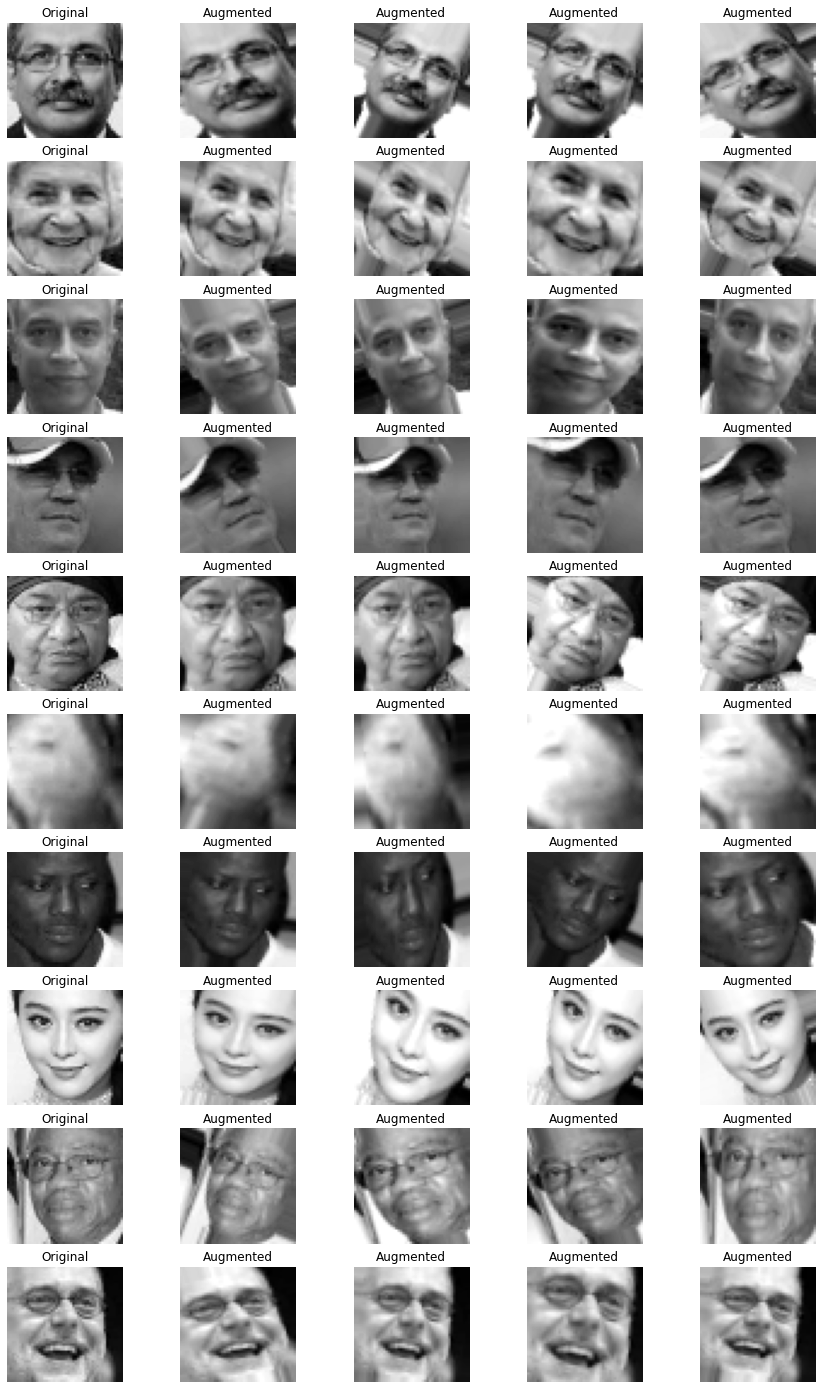

In [18]:
fig,ax = plt.subplots(10,5,figsize=(15,25))
for n in range(10):    
    r = random.sample(range(X.shape[0]),1)[0]
    ax[n,0].imshow(X[r].reshape(48,48),cmap="gray")
    ax[n,0].set_title("Original")
    ax[n,0].axis("off")
    for i in range(1,5):
        ax[n,i].imshow(train_data_gen.random_transform(X[r]).reshape(48,48),cmap="gray")
        ax[n,i].set_title("Augmented")
        ax[n,i].axis("off")
plt.show()

Training

In [19]:
# Model configuration
batch_size = 32
img_width, img_height, img_num_channels = 48, 48, 1
loss_function = sparse_categorical_crossentropy
no_classes = 2
no_epochs = 50
optimizer = Adam()
verbosity = 1
num_folds = 10
activation='softmax'

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)
input_shape

(48, 48, 1)

In [20]:
# Set Seed
random.seed(11)
set_seed(11)
np.random.seed(11)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

In [21]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y_gender):
    
  # Set Seed
  random.seed(11)
  set_seed(11)
  np.random.seed(11)
  
  # Define the model architecture
  model = Sequential()
  
  model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  

  model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='softmax'))

  # Compile the model
  model.compile(loss=loss_function,optimizer=optimizer,
              metrics=['accuracy'])
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
    
  early_stop = EarlyStopping(monitor="val_loss",patience=5,mode="min") # Ensure the model doesn't overfit
  
  # Set Seed
  random.seed(11)
  set_seed(11)
  np.random.seed(11)
   # Fit data to model
  history = model.fit(train_data_gen.flow(X[train], y_gender[train], seed=11),
            callbacks=early_stop,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_data=train_data_gen.flow(X[test], y_gender[test],
                                   seed=11))
  
  # Generate generalization metrics
  fig = px.line(
  history.history, y=['loss', 'val_loss'],
  labels={'index': 'epoch', 'value': 'loss'}, 
  title='Training History')
  fig.show()
    
  scores = model.evaluate(train_data_gen.flow(X[test], y_gender[test],
                                   seed=11), verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

  

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
548/548 [==============================] - 47s 27ms/step - loss: 0.5359 - accuracy: 0.7806 - val_loss: 0.5658 - val_accuracy: 0.6879
Epoch 2/50
548/548 [==============================] - 15s 28ms/step - loss: 0.3153 - accuracy: 0.8687 - val_loss: 0.3692 - val_accuracy: 0.8429
Epoch 3/50
548/548 [==============================] - 15s 27ms/step - loss: 0.2856 - accuracy: 0.8843 - val_loss: 0.3293 - val_accuracy: 0.8650
Epoch 4/50
548/548 [==============================] - 14s 26ms/step - loss: 0.2619 - accuracy: 0.8967 - val_loss: 0.2308 - val_accuracy: 0.9107
Epoch 5/50
548/548 [==============================] - 14s 26ms/step - loss: 0.2422 - accuracy: 0.9060 - val_loss: 0.2613 - val_accuracy: 0.8922
Epoch 6/50
548/548 [==============================] - 15s 27ms/step - loss: 0.2371 - accuracy: 0.9072 - val_loss: 0.2739 - val_accuracy: 0.8886
Epoch 7/50
548/548 [===================

Score for fold 1: loss of 0.18410564959049225; accuracy of 92.60780215263367%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50
548/548 [==============================] - 15s 26ms/step - loss: 0.6148 - accuracy: 0.7143 - val_loss: 0.7981 - val_accuracy: 0.5939
Epoch 2/50
548/548 [==============================] - 15s 28ms/step - loss: 0.3906 - accuracy: 0.8311 - val_loss: 0.3778 - val_accuracy: 0.8403
Epoch 3/50
548/548 [==============================] - 15s 27ms/step - loss: 0.3220 - accuracy: 0.8661 - val_loss: 0.4310 - val_accuracy: 0.8121
Epoch 4/50
548/548 [==============================] - 14s 26ms/step - loss: 0.2890 - accuracy: 0.8823 - val_loss: 0.2610 - val_accuracy: 0.8937
Epoch 5/50
548/548 [==============================] - 14s 25ms/step - loss: 0.2633 - accuracy: 0.8989 - val_loss: 0.3529 - val_accuracy: 0.8496
Epoch 6/50
548/548 [==============================] - 15s 27ms/step - loss: 0.2536 - accuracy: 0.8984 - v

Score for fold 2: loss of 0.20886176824569702; accuracy of 92.3511266708374%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/50
548/548 [==============================] - 15s 26ms/step - loss: 0.5937 - accuracy: 0.7291 - val_loss: 0.6843 - val_accuracy: 0.6040
Epoch 2/50
548/548 [==============================] - 15s 27ms/step - loss: 0.3749 - accuracy: 0.8383 - val_loss: 0.3194 - val_accuracy: 0.8737
Epoch 3/50
548/548 [==============================] - 15s 28ms/step - loss: 0.3141 - accuracy: 0.8727 - val_loss: 0.2900 - val_accuracy: 0.8850
Epoch 4/50
548/548 [==============================] - 14s 26ms/step - loss: 0.2826 - accuracy: 0.8860 - val_loss: 0.2645 - val_accuracy: 0.8978
Epoch 5/50
548/548 [==============================] - 14s 25ms/step - loss: 0.2618 - accuracy: 0.8957 - val_loss: 0.2943 - val_accuracy: 0.8901
Epoch 6/50
548/548 [==============================] - 15s 27ms/step - loss: 0.2437 - accuracy: 0.9046 - va

Score for fold 3: loss of 0.15831996500492096; accuracy of 94.35028433799744%
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50
548/548 [==============================] - 15s 26ms/step - loss: 0.5386 - accuracy: 0.7674 - val_loss: 0.6151 - val_accuracy: 0.6595
Epoch 2/50
548/548 [==============================] - 14s 25ms/step - loss: 0.3445 - accuracy: 0.8564 - val_loss: 0.3732 - val_accuracy: 0.8433
Epoch 3/50
548/548 [==============================] - 14s 26ms/step - loss: 0.2999 - accuracy: 0.8771 - val_loss: 0.2984 - val_accuracy: 0.8706
Epoch 4/50
548/548 [==============================] - 15s 28ms/step - loss: 0.2832 - accuracy: 0.8868 - val_loss: 0.3360 - val_accuracy: 0.8582
Epoch 5/50
548/548 [==============================] - 14s 26ms/step - loss: 0.2575 - accuracy: 0.8969 - val_loss: 0.2904 - val_accuracy: 0.8752
Epoch 6/50
548/548 [==============================] - 15s 28ms/step - loss: 0.2427 - accuracy: 0.9060 - v

Score for fold 4: loss of 0.17729535698890686; accuracy of 92.60400533676147%
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/50
548/548 [==============================] - 16s 28ms/step - loss: 0.5650 - accuracy: 0.7540 - val_loss: 0.4519 - val_accuracy: 0.7838
Epoch 2/50
548/548 [==============================] - 14s 25ms/step - loss: 0.3503 - accuracy: 0.8492 - val_loss: 0.3971 - val_accuracy: 0.8331
Epoch 3/50
548/548 [==============================] - 14s 25ms/step - loss: 0.3098 - accuracy: 0.8712 - val_loss: 0.3119 - val_accuracy: 0.8675
Epoch 4/50
548/548 [==============================] - 13s 24ms/step - loss: 0.2803 - accuracy: 0.8849 - val_loss: 0.2780 - val_accuracy: 0.8901
Epoch 5/50
548/548 [==============================] - 15s 27ms/step - loss: 0.2568 - accuracy: 0.8971 - val_loss: 0.3880 - val_accuracy: 0.8105
Epoch 6/50
548/548 [==============================] - 15s 27ms/step - loss: 0.2409 - accuracy: 0.9073 - v

Score for fold 5: loss of 0.22762596607208252; accuracy of 91.21725559234619%
------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/50
548/548 [==============================] - 15s 26ms/step - loss: 0.5887 - accuracy: 0.7378 - val_loss: 0.8060 - val_accuracy: 0.5824
Epoch 2/50
548/548 [==============================] - 15s 27ms/step - loss: 0.3765 - accuracy: 0.8401 - val_loss: 0.3299 - val_accuracy: 0.8577
Epoch 3/50
548/548 [==============================] - 15s 28ms/step - loss: 0.3265 - accuracy: 0.8648 - val_loss: 0.3321 - val_accuracy: 0.8649
Epoch 4/50
548/548 [==============================] - 15s 26ms/step - loss: 0.2933 - accuracy: 0.8801 - val_loss: 0.2799 - val_accuracy: 0.8875
Epoch 5/50
548/548 [==============================] - 15s 28ms/step - loss: 0.2729 - accuracy: 0.8918 - val_loss: 0.3403 - val_accuracy: 0.8505
Epoch 6/50
548/548 [==============================] - 14s 26ms/step - loss: 0.2549 - accuracy: 0.9008 - v

Score for fold 6: loss of 0.20600666105747223; accuracy of 91.37133955955505%
------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/50
548/548 [==============================] - 16s 27ms/step - loss: 0.6022 - accuracy: 0.7175 - val_loss: 0.6811 - val_accuracy: 0.6379
Epoch 2/50
548/548 [==============================] - 16s 28ms/step - loss: 0.3625 - accuracy: 0.8418 - val_loss: 0.2998 - val_accuracy: 0.8762
Epoch 3/50
548/548 [==============================] - 15s 27ms/step - loss: 0.3155 - accuracy: 0.8706 - val_loss: 0.3349 - val_accuracy: 0.8531
Epoch 4/50
548/548 [==============================] - 15s 28ms/step - loss: 0.2832 - accuracy: 0.8839 - val_loss: 0.2809 - val_accuracy: 0.8803
Epoch 5/50
548/548 [==============================] - 14s 26ms/step - loss: 0.2632 - accuracy: 0.8965 - val_loss: 0.2419 - val_accuracy: 0.9024
Epoch 6/50
548/548 [==============================] - 14s 25ms/step - loss: 0.2482 - accuracy: 0.9005 - v

Score for fold 7: loss of 0.14820802211761475; accuracy of 94.70980763435364%
------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/50
548/548 [==============================] - 17s 29ms/step - loss: 0.6043 - accuracy: 0.7210 - val_loss: 0.7869 - val_accuracy: 0.6030
Epoch 2/50
548/548 [==============================] - 16s 29ms/step - loss: 0.3802 - accuracy: 0.8345 - val_loss: 0.4184 - val_accuracy: 0.8166
Epoch 3/50
548/548 [==============================] - 16s 28ms/step - loss: 0.3236 - accuracy: 0.8673 - val_loss: 0.3108 - val_accuracy: 0.8788
Epoch 4/50
548/548 [==============================] - 16s 29ms/step - loss: 0.2931 - accuracy: 0.8807 - val_loss: 0.2583 - val_accuracy: 0.8947
Epoch 5/50
548/548 [==============================] - 15s 27ms/step - loss: 0.2773 - accuracy: 0.8868 - val_loss: 0.3075 - val_accuracy: 0.8695
Epoch 6/50
548/548 [==============================] - 15s 27ms/step - loss: 0.2512 - accuracy: 0.9023 - v

Score for fold 8: loss of 0.19879260659217834; accuracy of 92.75808930397034%
------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/50
548/548 [==============================] - 17s 30ms/step - loss: 0.5625 - accuracy: 0.7473 - val_loss: 0.4794 - val_accuracy: 0.7601
Epoch 2/50
548/548 [==============================] - 16s 28ms/step - loss: 0.3511 - accuracy: 0.8521 - val_loss: 0.4502 - val_accuracy: 0.7869
Epoch 3/50
548/548 [==============================] - 16s 30ms/step - loss: 0.3045 - accuracy: 0.8758 - val_loss: 0.2961 - val_accuracy: 0.8721
Epoch 4/50
548/548 [==============================] - 15s 27ms/step - loss: 0.2809 - accuracy: 0.8848 - val_loss: 0.2768 - val_accuracy: 0.8891
Epoch 5/50
548/548 [==============================] - 15s 27ms/step - loss: 0.2560 - accuracy: 0.8984 - val_loss: 0.2529 - val_accuracy: 0.8988
Epoch 6/50
548/548 [==============================] - 15s 28ms/step - loss: 0.2483 - accuracy: 0.9011 - v

Score for fold 9: loss of 0.2497183233499527; accuracy of 90.80637097358704%
------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/50
548/548 [==============================] - 16s 28ms/step - loss: 0.6171 - accuracy: 0.7272 - val_loss: 0.4393 - val_accuracy: 0.7951
Epoch 2/50
548/548 [==============================] - 15s 27ms/step - loss: 0.3641 - accuracy: 0.8438 - val_loss: 0.3104 - val_accuracy: 0.8737
Epoch 3/50
548/548 [==============================] - 16s 29ms/step - loss: 0.3195 - accuracy: 0.8692 - val_loss: 0.2776 - val_accuracy: 0.8942
Epoch 4/50
548/548 [==============================] - 16s 29ms/step - loss: 0.2923 - accuracy: 0.8822 - val_loss: 0.2649 - val_accuracy: 0.9060
Epoch 5/50
548/548 [==============================] - 16s 29ms/step - loss: 0.2714 - accuracy: 0.8914 - val_loss: 0.3677 - val_accuracy: 0.8603
Epoch 6/50
548/548 [==============================] - 16s 29ms/step - loss: 0.2572 - accuracy: 0.8986 - v

Score for fold 10: loss of 0.13438060879707336; accuracy of 94.96661424636841%
